<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Partie-1:-Présentation-du-modèle" data-toc-modified-id="Partie-1:-Présentation-du-modèle-1">Partie 1: Présentation du modèle</a></span></li><li><span><a href="#Partie-2:-Trouver-$P$-quand-$Q_0$-est-fixé" data-toc-modified-id="Partie-2:-Trouver-$P$-quand-$Q_0$-est-fixé-2">Partie 2: Trouver $P$ quand $Q_0$ est fixé</a></span></li><li><span><a href="#Partie-3:-Raffinements-algorithmiques-pour-le-problème-à-$Q_0$-fixé." data-toc-modified-id="Partie-3:-Raffinements-algorithmiques-pour-le-problème-à-$Q_0$-fixé.-3">Partie 3: Raffinements algorithmiques pour le problème à $Q_0$ fixé.</a></span></li><li><span><a href="#Partie-4:-Résolution-du-problème-complet" data-toc-modified-id="Partie-4:-Résolution-du-problème-complet-4">Partie 4: Résolution du problème complet</a></span></li></ul></div>

# SD211 TP1: Systèmes de recommandation

*<p>Author: Pengfei MI</p>*
*<p>Date: 05/05/2017</p>*

In [1]:
# Importer les bibliothéques qu'on va utiliser.
# from movielens_utils import *
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
from scipy.sparse.linalg import svds
from scipy.optimize import check_grad
from scipy.optimize import line_search

In [2]:
def load_movielens(filename, minidata=False):
    """
    Cette fonction lit le fichier filename de la base de donnees
    Movielens, par exemple 
    filename = '~/datasets/ml-100k/u.data'
    Elle retourne 
    R : une matrice utilisateur-item contenant les scores
    mask : une matrice valant 1 si il y a un score et 0 sinon
    """

    data = np.loadtxt(filename, dtype=int)

    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),
                          dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape),
                              (data[:, 0]-1, data[:, 1]-1)), dtype=bool )
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask

## Partie 1: Présentation du modèle

$\textbf{Question 1.1}\quad \text{Récupérer la base de données Movielens.}$

In [3]:
filename = "ml-100k/u.data"
R, mask = load_movielens(filename, minidata=False)

print R.shape

(943, 1682)


<div class="alert alert-success">
    <p>
    L'option $minidata$ est pour diminuer la taille de données. Si on passe $True$ pour le paramètre $minidata$, la fonction va retourner les note des 100 premiers utilisateurs pour les 200 premiers films.
    </p>
</div>

$\textbf{Question 1.2}\quad \text{Investigation de la base de données.}$

In [4]:
print R.shape, mask.sum()

(943, 1682) 100000


<div class="alert alert-success">
    <p>
    Dans la base de données, il y a 943 utilisateurs et 1682 films. Il y a 100 000 notes en total.
    </p>
</div>


$\textbf{Question 1.3}\quad \text{Investigation de la fonction objectif.}$

<div class="alert alert-success">
    a)
    <p>
    La fonction n'est pas convexe. Pour le démontrer, on n'a que besoin de trouver une contradiction.
    </p>
    <p>
    Posons $|U| = |C| = 1$, la fonction objectif devient une fonction dont le domaine est $\mathbb{R\times R}$, i.e. $g(x, y) = \frac{1}{2}(1-xy)^2 + \frac{\rho}{2}(x^2+y^2)$.
    </p>
    <p>
    On obtient le dessin de la fonction:
    </p>
</div>

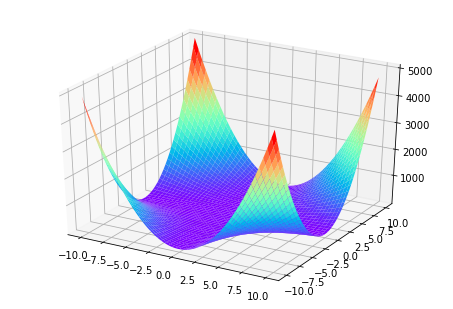

In [5]:
fig = plt.figure(1)
ax = Axes3D(fig)

rho = 0.2
X = np.arange(-10, 10, 0.1)
Y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(X, Y)
Z = (1 - X*Y)**2/2. + rho/2.*(X**2 + Y**2)
ax.plot_surface(X, Y, Z, cmap='rainbow')
plt.show()

<div class="alert alert-success">
    <p>
    On trace la valeur de cette fonction sur le ligne $x+y=10$ dans son domaine.
    </p>
</div>

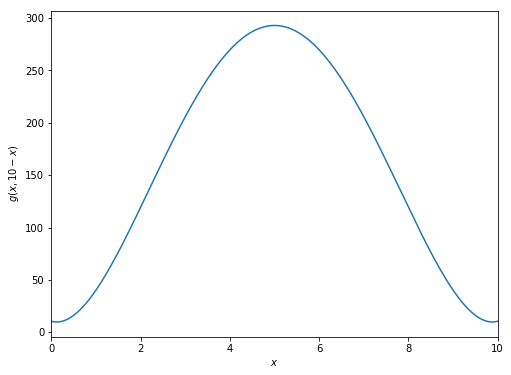

In [6]:
X = np.arange(0, 10.01, 0.01)
Y = 10 - X
Z = (1 - X*Y)**2/2. + rho/2.*(X**2 + Y**2)
plt.figure(2, figsize=(8,6))
plt.plot(X, Z)
plt.xlabel("$x$")
plt.ylabel("$g(x, 10-x)$")
plt.xlim(0, 10)
plt.show()

<div class="alert alert-success">
    <p>
    Soient $p1=(0,10), p2=(10,0)$, on a $p3=(5,5)=0.5p1+(1-0.5)p2$.
    </p>
</div>

In [7]:
g1 = (1 - 0*10)**2/2. + rho/2.*(0**2 + 10**2)
g2 = (1 - 10*0)**2/2. + rho/2.*(10**2 + 0**2)
g3 = (1 - 5*5)**2/2. + rho/2.*(5**2 + 5**2)
print "g(p1) = %f" % g1
print "g(p2) = %f" % g2
print "g(p3) = %f" % g3

g(p1) = 10.500000
g(p2) = 10.500000
g(p3) = 293.000000


<div class="alert alert-success">
    <p>
    Donc on a $t\cdot g(p1)+(1-t)g(p2) \leq g(t\cdot p1+(1-t)p2)$, donc la fonction objectif n'est pas convexe.
    </p>
</div>

<div class="alert alert-success">
    b)
    <p>Notons $g$ la fonction objectif. On a:</p>
    <p>$g(P,Q) = \frac{1}{2}\|1_K\circ(R-QP)\|_F^2 + \frac{\rho}{2}\|Q\|_F^2 + \frac{\rho}{2}\|P\|_F^2$</p>
    <p>On obtient ses gradients par rapport à $P$ et $Q$:</p>
    <p>$\nabla_g(P) = -Q^T(1_K\circ(R-QP)) + \rho P$</p>
    <p>$\nabla_g(Q) = -(1_K\circ(R-QP))P^T + \rho Q$</p>
</div>

<div class="alert alert-success">
    c) 
    <p>Les deux gradients ne sont pas lipschitzien.</p>
    <p>Par le même exemple, $g(x, y) = \frac{1}{2}(1-xy)^2 + \frac{\rho}{2}(x^2+y^2)$, on a:</p>
    $$\frac{\partial g}{\partial x} = (y^2+\rho)x - y$$
    $$\frac{\partial^2 g}{\partial x^2} = y^2 + \rho$$
    <p>Quand $y \rightarrow \infty$, $\frac{\partial^2 g}{\partial x^2} \rightarrow \infty$, donc $\nabla_g(P)$ n'est pas lipschitzien. De la même façon, on peut conclure que $\nabla_g(Q)$ n'est pas lipschitzien.</p>
</div>

## Partie 2: Trouver $P$ quand $Q_0$ est fixé

$\textbf{Question 2.1}\quad \text{Investigation de la fonction objectif simplifiée.}$

<div class="alert alert-success">
    <p>La fonction objectif est convexe.</p>
    <p>Son gradient est: $\nabla_g(P) = -(Q^0)^T(1_K\circ(R-Q^0P)) + \rho P$. On a:</p>
    <p>$\nabla_g^2(P) = (Q^0)^TQ^0 + \rho I_{|C|}$, cette matrice est définitivement positive. Donc $g(P)$ est convexe.</p>
</div>

$\textbf{Question 2.2}\quad \text{Calculer le gradient.}$

<div class="alert alert-success">
    <p>On utilise la conclusion de la question précédente pour compléter la fonction.</p>
</div>

In [8]:
def objective(P, Q0, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q0 : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    """

    tmp = (R - Q0.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2.*(np.sum(Q0.T**2) + np.sum(P**2))

    grad_P = -Q0.T.dot(tmp) + rho*P

    return val, grad_P

In [9]:
# Initialize the varibles;
rho = 0.2
CC = 7
R, mask = load_movielens(filename, minidata=False)
u, i = R.shape
U, S, V_T = svds(R, k=CC, return_singular_vectors=True)

def funcObj(P_vec, Q0, R, mask, rho, c):
    P = P_vec.reshape(c, i)
    val, grad_P = objective(P, Q0, R, mask, rho)
    return val

def gradObj(P_vec, Q0, R, mask, rho, c):
    P = P_vec.reshape(c, i)
    val, grad_P = objective(P, Q0, R, mask, rho)
    return grad_P.ravel()

t0 = time()
print "The difference of gradient is %f" % check_grad(funcObj, gradObj, np.zeros_like(V_T).ravel(), U, R, mask, rho, CC)
print "Done in %0.3fs." % (time()-t0)

The difference of gradient is 1.009426
Done in 284.356s.


$\textbf{Question 2.3}\quad \text{Minimiser une fonction }g\text{ par la méthode du gradient.}$

In [10]:
def gradient(g, P0, gamma, epsilon):
    P = P0
    val, grad_P = g(P, U, R, mask, rho)
    cnt = 0
    while (np.sum(grad_P**2) > epsilon**2):
        P = P - gamma*grad_P
        val, grad_P = g(P, U, R, mask, rho)
        cnt = cnt + 1
    return val, P, cnt

$\textbf{Question 2.4}\quad \text{minimiser la fonction }g\text{ jusqu’à la précision }\epsilon\text{ = 1.}$

<div class="alert alert-success">
    <p>On fait une décomposition SVD, et utilise les $|C|$ premiers vecteurs singuliers à gauche comme la valeur de $Q_0$, et la matrice nulle de taille $|C|\times|I|$ comme la valeur initialse de $P$.</p>
    <p>On calcule la constante de Lipschitz de $\nabla_g(P)$, $L$, et utilise $\frac{1}{L}$ comme la longueur de pas.</p>
</div>

In [11]:
R, mask = load_movielens(filename, minidata=False)
U, S, V_T = svds(R, k=CC, return_singular_vectors=True)

t0 = time()
L = rho + np.sqrt(np.sum(U.T**2))
gamma = 1./L
val_grad, P, cnt_grad = gradient(objective, np.zeros_like(V_T), gamma, 1)
print "The minimal value of target function is %f" % val_grad
print "The solution of matrix P is:"
print P
t_grad = time() - t0
print "Done in %0.3fs, number of iteration: %d." % (t_grad, cnt_grad)

The minimal value of target function is 297828.942767
The solution of matrix P is:
[[-10.77942487  -0.9416559    0.18022219 ...,  -0.18906111   0.40216237
   -0.10334136]
 [-18.34279537  -2.23521595   4.37226672 ...,   0.18412819  -0.08827117
    0.91265716]
 [ 18.71020626  -4.09213395   3.16975678 ...,  -0.82933845  -0.33457229
   -0.2638825 ]
 ..., 
 [ -3.1551629   14.04776233   2.83303405 ...,  -0.5105261    0.46211528
    0.25354201]
 [ 19.28452609   0.46371152  12.73748781 ...,   0.48239806  -0.12029391
   -0.22145778]
 [ 61.63593211  31.7434549   22.85318421 ...,   0.08555451   0.9902246
    0.90377783]]
Done in 1.165s, number of iteration: 46.


## Partie 3: Raffinements algorithmiques pour le problème à $Q_0$ fixé.

$\textbf{Question 3.1}\quad\text{Rajouter une méthode de recherche linéaire à la méthode de gradient.}$

<div class="alert alert-success">
    <p>La solution exacte d'un problème de recherche linéaire est la solution du problème d'optimisation:</p>
    $$\gamma_k = arg\,\underset{\gamma\in\mathbb{R}_+}{min} g(P^k-\gamma\nabla_g(P^k))$$
    <p>En pratique, on fait une recherche linéaire d'Armijo. Notons $P^+(\gamma_k)=P^k - \gamma_k\nabla_g(P^k)$, on cherche le premier entier $l$ tel que:</p>
    $$g(P^+(ba^l)) \leq g(P^k) + \beta\langle\nabla_g(P^k),\,P^+(ba^l)-P^k\rangle$$.
    <p>On fixe $a = 0.5, b = 0.5, \beta = 0.5$, c'est équivalent à la recherche linéaire de Taylor.</p>
</div>

In [12]:
def gradient_LS(func, P0, a, b, beta, epsilon):
    P = P0
    val, grad_P = func(P, U, R, mask, rho)
    grad_norm_square = np.sum(grad_P**2)
    gamma = b
    cnt = 0
    while (grad_norm_square > epsilon**2):
        gamma = 2*gamma
        val_, grad_P_ = func(P - gamma*grad_P, U, R, mask, rho)
        while (val_ > val - gamma*beta*grad_norm_square):
            gamma = gamma*a
            val_, grad_P_ = func(P - gamma*grad_P, U, R, mask, rho)
        P = P - gamma*grad_P
        val = val_
        grad_P = grad_P_
        grad_norm_square = np.sum(grad_P**2)
        cnt = cnt + 1
    return val, P, cnt

R, mask = load_movielens(filename, minidata=False)
U, S, V_T = svds(R, k=CC, return_singular_vectors=True)

t0 = time()
a = 0.5
b = 0.5
beta = 0.5
val_ls, P, cnt_ls = gradient_LS(objective, np.zeros_like(V_T), a, b, beta, 1)
print "The minimal value of target function is %f" % val_ls
print "The solution of matrix P is:"
print P
t_ls = time() - t0
print "Done in %0.3fs, number of iteration: %d." % (t_ls, cnt_ls)

The minimal value of target function is 297828.066132
The solution of matrix P is:
[[ 10.78005639   0.9421978   -0.17977375 ...,   0.1899091   -0.40369983
    0.10379408]
 [ 18.34362553   2.24563901  -4.35460455 ...,  -0.18495405   0.08860863
   -0.91665531]
 [-18.70811729   4.07666309  -3.18927586 ...,   0.83305824   0.33585135
    0.26503851]
 ..., 
 [  3.15748024 -14.03270126  -2.8362182  ...,   0.51281594  -0.46388194
   -0.25465272]
 [-19.28602013  -0.47193566 -12.7374957  ...,  -0.48456173   0.12075379
    0.22242794]
 [ 61.64143679  31.765725    22.87579846 ...,   0.08593825   0.99401021
    0.90773708]]
Done in 0.422s, number of iteration: 9.


$\textbf{Question 3.2}\quad\text{Utiliser la méthode du gradient conjugué pour ce problème.}$

<div class="alert alert-success">
    <p>On a vu dans les questions précédentes que $\nabla_g^2(P) = (Q^0)^TQ^0 + \rho I_{|C|}$, c'est une matrice symétrique et définitivement positive. Donc on peut appliquer la méthode du gradient conjugué pour résoudre ce problème.</p>
    <p>Dans le code ci-dessous, pour trouver une solution exacte dans la partie de recherche linéaire, on utilise la founction $line\_search$ offert par scipy.</p>
</div>

In [13]:
shape = V_T.shape

def funcObj(P_vec):
    P = P_vec.reshape(shape)
    val = np.sum(((R - U.dot(P))*mask)**2)/2. + rho/2.*(np.sum(U.T**2) + np.sum(P**2))
    return val

def gradObj(P_vec):
    P = P_vec.reshape(shape)
    grad_P = -U.T.dot(mask*(R - U.dot(P))) + rho*P
    return grad_P.ravel()

def gradient_cg(func, grad, P0, epsilon):
    P = P0
    val = func(P)
    grad_P = grad(P)
    grad_norm_square = np.sum(grad_P**2)
    d = -grad_P
    cnt = 0
    while (grad_norm_square > epsilon**2):
        #alpha = np.sqrt(np.sum((U.T.dot(U.dot(P)-R) + rho*P)**2))/np.sqrt(np.sum((U.T.dot(mask*U.dot(grad_P)) + rho*grad_P)**2))
        alpha, fc, gc, val, old_fval, new_slope = line_search(func, grad, xk=P, pk=d)
        P = P + alpha*d
        grad_P = grad(P)
        grad_norm_square_ = np.sum(grad_P**2)
        beta = grad_norm_square_/grad_norm_square
        d = -grad_P + beta*d
        grad_norm_square = grad_norm_square_
        cnt = cnt + 1
    return val, P.reshape(shape), cnt

R, mask = load_movielens(filename, minidata=False)
U, S, V_T = svds(R, k=CC, return_singular_vectors=True)

t0 = time()
val_cg, P, cnt_cg = gradient_cg(funcObj, gradObj, np.zeros(shape).ravel(), 1)
print "The minimal value of target function is %f" % val_cg
print "The solution of matrix P is:"
print P
t_cg = time() - t0
print "Done in %0.3fs, number of iteration: %d." % (t_cg, cnt_cg)

The minimal value of target function is 297827.645759
The solution of matrix P is:
[[ 10.77619821   0.94253379  -0.17947528 ...,   0.19111122  -0.40587243
    0.10443408]
 [-18.3398119   -2.25375222   4.33552775 ...,   0.1861248   -0.08908549
    0.92230745]
 [-18.70597383   4.04984439  -3.20994233 ...,   0.83833147   0.33765881
    0.26667275]
 ..., 
 [  3.14990157 -14.00271878  -2.85212026 ...,   0.51606204  -0.46637842
   -0.25622293]
 [ 19.27794441   0.48999638  12.73283943 ...,   0.48762899  -0.12140365
   -0.22379944]
 [-61.64851632 -31.78555795 -22.9163201  ...,  -0.08648223  -0.9993597
   -0.91333423]]
Done in 1.119s, number of iteration: 10.


$\textbf{Question 3.3}\quad\text{Comparer les performances des trois algorithmes.}$

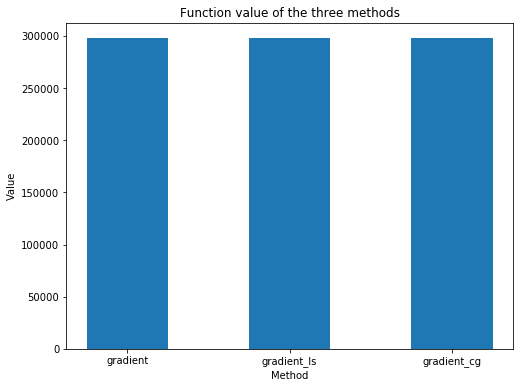

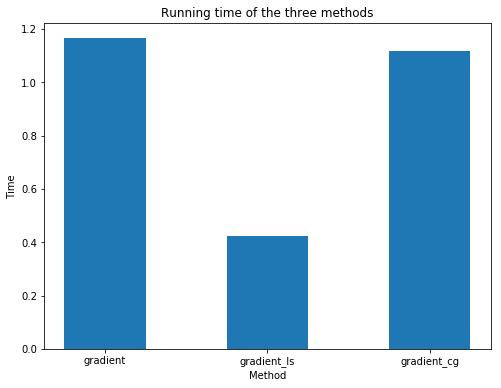

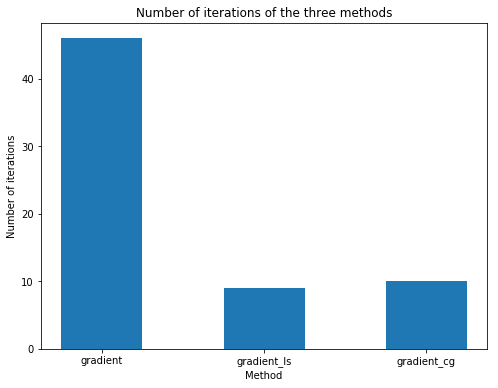

In [14]:
index = np.arange(3)
bar_width = 0.5
methods = ["gradient", "gradient_ls", "gradient_cg"]
times = [t_grad, t_ls, t_cg]
values = [val_grad, val_ls, val_cg]
cnts = [cnt_grad, cnt_ls, cnt_cg]

plt.figure(3, figsize=(8,6))
plt.title("Function value of the three methods")
plt.bar(index, values, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Value")
plt.show()

plt.figure(4, figsize=(8,6))
plt.title("Running time of the three methods")
plt.bar(index, times, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Time")
plt.show()

plt.figure(5, figsize=(8,6))
plt.title("Number of iterations of the three methods")
plt.bar(index, cnts, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Number of iterations")
plt.show()

<div class="alert alert-success">
    <p>Les valeurs minimales trouvées par les trois algorithmes sont très proches, la valeur minimale trouvée par la méthode du gradient conjugué est un peu meilleur. En comparant les matrices $P$ qu'ils obtiennent, ils trouvent en fait la même solution.</p>
    <p>Le temps d'execution de la méthode du gradient avec recherche linéaire est meilleur que les autres. On doit considérer le fait que les détails de réalisation des fonctions sont différents.</p>
    <p>Le nombre d'itérations de la méthode recherche linéaire et gradient conjugué est meilleur que la méthode du gradient originale.</p>
</div>

## Partie 4: Résolution du problème complet

$\textbf{Question 4.1}\quad\text{Résoudre le problème complet par la méthode du gradient avec recherche linéaire.}$

<div class="alert alert-success">
    <p>On fait une combinaison entre $P$ et $Q$ et les comsidère comme une seule variable, après, on applique la méthode qu'on a réalisé dans la question précédente.</p>
</div>

In [15]:
def total_objective(P, Q, R, mask, rho):
    """
    La fonction objectif du probleme complet.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q : la variable matricielle de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp**2)/2. + rho/2.*(np.sum(Q**2) + np.sum(P**2))

    grad_P = -Q.T.dot(mask*(R - Q.dot(P))) + rho*P

    grad_Q = -(mask*(R - Q.dot(P))).dot(P.T) + rho*Q

    return val, grad_P, grad_Q


def total_objective_vectorized(PQvec, R, mask, rho):
    """
    Vectorisation de la fonction precedente de maniere a ne pas
    recoder la fonction gradient
    """

    # reconstruction de P et Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = PQvec.shape[0]/(n_items + n_users)
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))

    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, np.concatenate([grad_P.ravel(), grad_Q.ravel()])

In [16]:
def gradient_LS(func, PQ0, a, b, beta, epsilon):
    PQ = PQ0
    val, grad = func(PQ, R, mask, rho)
    grad_norm_square = np.sum(grad**2)
    gamma = b
    cnt = 0
    while (grad_norm_square > epsilon**2):
        gamma = 2 * gamma
        PQ_ = PQ - gamma*grad
        val_, grad_ = func(PQ_, R, mask, rho)
        while (val_ > val - gamma*beta*grad_norm_square):
            gamma = gamma*a
            PQ_ = PQ - gamma*grad
            val_, grad_ = func(PQ_, R, mask, rho)
        PQ = PQ_
        val = val_
        grad = grad_
        grad_norm_square = np.sum(grad**2)
        cnt = cnt + 1
    return val, PQ, cnt

R, mask = load_movielens(filename, minidata=False)
U, S, V_T = svds(R, k=CC, return_singular_vectors=True)

t0 = time()
a = 0.5
b = 1
beta = 0.5
val_grad, PQvec, cnt_grad = gradient_LS(total_objective_vectorized, np.concatenate([V_T.ravel(), U.ravel()]), a, b, beta, 100)
n_items = R.shape[1]
n_users = R.shape[0]
F = PQvec.shape[0]/(n_items + n_users)
Pvec = PQvec[0:n_items*F]
Qvec = PQvec[n_items*F:]
P_grad = np.reshape(Pvec, (F, n_items))
Q_grad = np.reshape(Qvec, (n_users, F))
print "The minimal value of target function is %f" % val_grad
print "The solution of matrix P is:"
print P_grad
print "The solution of matrix Q is:"
print Q_grad
t_grad = time() - t0
print "Done in %0.3fs, number of iteration: %d." % (t_grad, cnt_grad)

The minimal value of target function is 31251.876721
The solution of matrix P is:
[[-0.43268288 -0.09016575  0.323656   ..., -0.09742755 -0.05754973
  -0.03071732]
 [-0.60822171  0.13042095  0.31722995 ..., -0.02837241 -0.15583947
   0.22812648]
 [ 0.54359261  0.09133388  0.08788494 ..., -0.34840142 -0.01014035
  -0.02304787]
 ..., 
 [-0.02274176  0.73670163  0.42947002 ..., -0.28939516  0.01861227
  -0.16654555]
 [ 0.51711182 -0.19525948  0.96135395 ...,  0.32514559 -0.13513027
  -0.08410091]
 [ 1.96692278  1.53677727  1.28430857 ...,  0.07070596  0.84176155
   0.81032142]]
The solution of matrix Q is:
[[-0.48958438 -0.12069678  0.31623349 ..., -0.31062729 -0.12376588
   2.17580846]
 [ 0.15937844 -0.18609562  0.68728097 ..., -0.92560733  0.62518605
   1.60930849]
 [ 0.03422688 -0.02779168 -1.11179171 ..., -0.21244451 -0.01147646
   1.38551953]
 ..., 
 [-0.41120076 -0.22219958  0.60660108 ..., -0.4742707   0.94231813
   1.67724062]
 [ 0.23688264  0.29932335  0.51515969 ...,  0.31036761

$\textbf{Question 4.2}\quad\text{Montrer que la valeur de l’objectif décroît à chaque itération. En déduire qu’elle converge.}$

<div class="alert alert-success">
    <p>Dans la question 2.1, on a démontré que quand $Q$ (resp. $P$) est fixé, la fonction $g(P)$ (resp. $g(Q)$) est convexe. Donc à chaque pas dans une itération, la valeur de la fonction objective décroît.</p>
    <p>L'algorithme est de la forme $x^{k+1} = T(x^k)$, où $T:x\rightarrow x$ est une fonction continuelle. Deplus, la fonction objectif est bien bornée. Nontons $x^*$ la solution optimale, on peut toujours obtenir une configuration plus proche à $x^*$ après une itération. Par le lemme du point-fixe, on conclure que l'algorithm va converger.</p>
</div>

$\textbf{Question 4.3}\quad\text{Coder la méthode des moindres carrés alternés.}$

<div class="alert alert-success">
<p>
Notons $P=(\mathbf{p}_1,...\mathbf{p}_{|I|})$, $Q=(\mathbf{q}_1,...\mathbf{q}_{|U|})^T$, où $\mathbf{p}_i, \mathbf{q}_u\in\mathbb{R}^{|C|}$, $K_u^I$ l'ensemble des films que l'utilisateur $u$ a noté, $K_i^U$ l'ensemble des utilisateurs qui ont noté le film $i$, on obtient:
</p>
$$
\begin{aligned}
g(P,Q) &= \frac{1}{2}\sum_{(u,i)\in K}(r_{ui}-\sum_{c\in C}q_{uc}p_{ci})^2 + \frac{\rho}{2}(\sum_{u,c}q_{uc}^{2}+\sum_{c,i}p_{ci}^{2}) \\
& = \frac{1}{2}\sum_{(u,i)\in K}(r_{ui}-\mathbf{q}_u^T\mathbf{p}_i)^2 + \frac{\rho}{2}(\sum_{u}\|\mathbf{q}_{u}\|^{2}+\sum_{i}\|\mathbf{p}_{i}\|^{2})\\
& = \frac{1}{2} \sum_{u\in U} \sum_{i\in K_u^I}(r_{ui}-\mathbf{q}_u^T\mathbf{p}_i)^2 + \frac{\rho}{2}(\sum_{u}\|\mathbf{q}_{u}\|^{2}+\sum_{i}\|\mathbf{p}_{i}\|^{2}) \\
& = \frac{1}{2} \sum_{i\in I} \sum_{u\in K_i^U}(r_{ui}-\mathbf{q}_u^T\mathbf{p}_i)^2 + \frac{\rho}{2}(\sum_{u}\|\mathbf{q}_{u}\|^{2}+\sum_{i}\|\mathbf{p}_{i}\|^{2})
\end{aligned} 
$$

<p>
Dans chaque itération, pour trouver la matrice $Q$ quand $P$ est fixée, on doit en fait résoudre un problème de moindre carré pénalisé. On calcule la dérivée partielle de $q_{uc}$ pour chaque couple $(u, c) \in \mathbf{U \times C}.$
</p>
$$
\begin{aligned}
&\quad\frac{\partial g}{\partial q_{uc}} = 0 \\
\Rightarrow &\quad\sum_{i\in K_u^I}(\mathbf{q}_u^T\mathbf{p}_i - r_{ui})p_{ci} + \rho q_{uc} = 0 \\
\Rightarrow &\quad\sum_{i\in K_u^I}p_{ci}\mathbf{p}_i^T\mathbf{q}_u + \rho q_{uc} = \sum_{i\in K_u^I}p_{ci}r_{ui} \\
\Rightarrow &\quad(P_{K_u}P_{K_u^I}^T + \rho I_{|C|})\mathbf{q}_u = P_{K_u^I}R^T(u, K_u^I)
\end{aligned}
$$
<p>On obtient l'expression explicite de $\mathbf{q}_u$ pour chaqun $u \in \mathbf{U}$ comme la solution d'un système linéaire:$\,\mathbf{q}_u = (P_{K_u^I}P_{K_u^I}^T + \rho I_{|C|})^{-1}P_{K_u^I}R^T(u, K_u^I)$, où $P_{K_u^I}$ est la sous-matrice de $P$ dont les colonnes $i \in K_u^I$ sont sélectionnées, $I_{|C|}$ est la matrice identité de taille $|C|\times|C|$, R(u, K_u^I) est le vecteur ligne où les éléments $i \in K_u^I$ du ligne $u$ de la matrice $R$ sont sélectionnés.
</p>
<p>
Réspectivement, on a $\mathbf{p}_i = (Q_{K_i^U}Q_{K_i^U}^T + \rho I_{|C|})^{-1}Q_{K_i^U}R(K_i^U,i)$, où $Q_{K_i^U}$ est la sous-matrice de $Q$ dont les lignes $u \in K_i^U$ sont sélectionnées, $I_{|C|}$ est la matrice identité de taille $|C|\times|C|$, $R(K_i^U,i)$ est le vecteur colonne où les éléments $u \in K_i^U$ du ligne $i$ de la matrice $R$ sont sélectionnés.
</p>
</div>

In [17]:
def ALS(P0, Q0, R, mask, rho, tol=1, max_iter=1e4):
    u, i = R.shape
    mask_i = [mask[:, k].ravel() for k in range(i)]
    mask_u = [mask[k, :].ravel() for k in range(u)]
    R_i = [R[mask_i[k], k] for k in range(i)]
    R_u = [R[k, mask_u[k]] for k in range(u)]
    P = P0
    Q = Q0
    val = 1e10
    delta_val = 1e10
    t = 0
    cnt = 0
    while (delta_val >= tol and t < max_iter):
        for k in range(i):
            Q_i = Q[mask_i[k], :]
            P[:, k] = np.linalg.solve(Q_i.T.dot(Q_i) + rho*np.identity(CC), Q_i.T.dot(R_i[k]))
        for k in range(u):
            P_u = P[:, mask_u[k]]
            Q[k, :] = np.linalg.solve(P_u.dot(P_u.T) + rho*np.identity(CC), P_u.dot(R_u[k].T))
        val_ = np.sum((mask*(R - Q.dot(P)))**2)/2. + rho/2.*(np.sum(Q**2) + np.sum(P**2))
        delta_val = val - val_
        val = val_
        t = t+1
    return val, P, Q, t

R, mask = load_movielens(filename, minidata=False)
U, S, V_T = svds(R, k=CC, return_singular_vectors=True)

t0 = time()
P0 = V_T
Q0 = U
tol = 1
max_iter = 1e4
val_als, P_als, Q_als, cnt_als = ALS(P0, Q0, R, mask, rho, tol, max_iter)
print "The minimal value of target function is %f" % val_als
print "The solution of matrix P is:"
print P_als
print "The solution of matrix Q is:"
print Q_als
t_als = time() - t0
print "Done in %0.3fs, number of iteration: %d." % (t_als, cnt_als)

The minimal value of target function is 28663.328313
The solution of matrix P is:
[[-1.11806081 -1.12759944 -0.81587608 ..., -0.65294021 -0.77553506
  -0.22185908]
 [ 0.10110321  0.39730903 -0.01297881 ...,  0.05035409 -0.03446964
   0.53949162]
 [ 1.10718679  0.71525278  1.29962729 ...,  0.20898636  0.13755371
   0.58694814]
 ..., 
 [ 0.65674954  0.0370439   0.38407317 ...,  0.40245454  0.77742169
   1.06372847]
 [ 0.26715828  0.18620119  0.84311226 ...,  0.31884758 -0.19298936
   0.31598334]
 [ 2.03892268  1.84576612  1.18789476 ...,  0.16880658  1.36461652
   0.78169487]]
The solution of matrix Q is:
[[-0.26467528  0.8880111   0.58724291 ...,  0.81020303 -0.36798596
   1.2688996 ]
 [-0.67582295  0.9089231   1.06987568 ...,  0.82194575  0.23319471
   0.41365481]
 [-0.39419228 -0.00628449  1.92719746 ...,  0.63101    -0.12883746
   0.282598  ]
 ..., 
 [ 0.03265985  0.47882814  0.38899956 ...,  0.62173534  0.9749038
   1.58733022]
 [-0.06271045  0.63872166  0.53418063 ...,  0.08913138 

$\textbf{Question 4.4}\quad\text{Comparer la méthode du gradient avec recherche linéaire et la méthode des moindres carrés alternés.}$

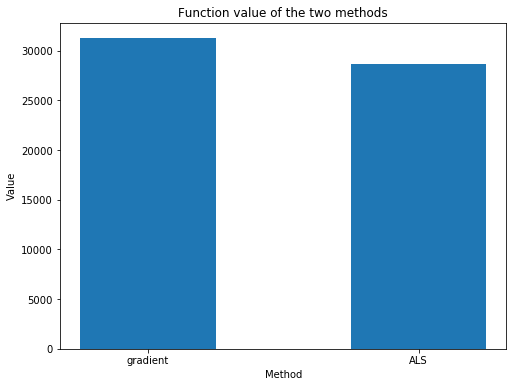

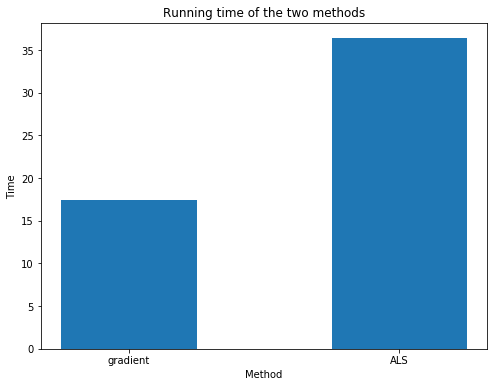

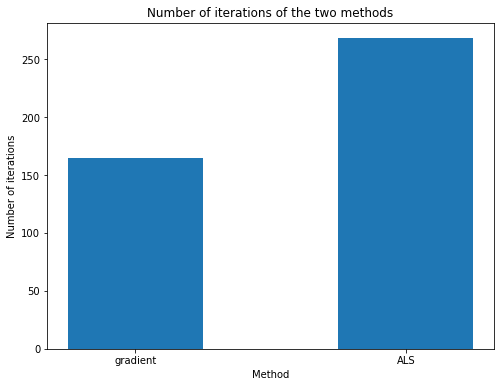

In [18]:
index = np.arange(2)
bar_width = 0.5
methods = ["gradient", "ALS"]
times = [t_grad, t_als]
values = [val_grad, val_als]
cnts = [cnt_grad, cnt_als]

plt.figure(6, figsize=(8,6))
plt.title("Function value of the two methods")
plt.bar(index, values, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Value")
plt.show()

plt.figure(7, figsize=(8,6))
plt.title("Running time of the two methods")
plt.bar(index, times, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Time")
plt.show()

plt.figure(8, figsize=(8,6))
plt.title("Number of iterations of the two methods")
plt.bar(index, cnts, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Number of iterations")
plt.show()

<div class="alert alert-success">
    <p>En comparant les matrice $P$ et $Q$ obtenues par les deux algorithmes, on peut conclure que les solution trouvées par eux sont différentes. Les matrices $\hat{R}$ sont aussi différentes.</p>
    <p>Les valeurs de la fonction objectif sont différentes, celle donnée par l'algorithm ALS est meilleur.</p>
    <p>En comparant le nombre d'irération, la méthode du gradient avec recherche linéaire est plus rapid. En même temps, les détails de réalisation peur être améliorée.</p>
</div>

$\textbf{Question 4.5}\quad\text{Quel film recommanderiez-vous à l’utilisateur 449?}$

<div class="alert alert-success">
    <p>On rétablit la matrice $\hat{R}$ selon les $P^*$ et $Q^*$ qu'on obtient dans les questions précédentes et mettre le ligne 449 en ordre.</p>
</div>

In [19]:
R_grad = Q_grad.dot(P_grad)
score = R_grad[449, :].ravel()
rank = (-score).argsort()
print "-----------------------------------------------------------------------"
print "By gradient method, the 10 favorite films of user 449 will be:"
for i in range(10):
    print "%d: movie %d, score %f" % (i+1, rank[i], score[rank[i]])

R_als = Q_als.dot(P_als)
score = R_als[449, :].ravel()
rank = (-score).argsort()
print "-----------------------------------------------------------------------"
print "By ALS method, the 10 favorite films of user 449 will be:"
for i in range(10):
    print "%d: movie %d, score %f" % (i+1, rank[i], score[rank[i]])

-----------------------------------------------------------------------
By gradient method, the 10 favorite films of user 449 will be:
1: movie 317, score 5.104734
2: movie 1168, score 5.005826
3: movie 482, score 4.866524
4: movie 63, score 4.835036
5: movie 962, score 4.821089
6: movie 1188, score 4.816720
7: movie 315, score 4.782925
8: movie 271, score 4.775279
9: movie 190, score 4.765647
10: movie 1642, score 4.760058
-----------------------------------------------------------------------
By ALS method, the 10 favorite films of user 449 will be:
1: movie 317, score 5.174918
2: movie 908, score 5.167129
3: movie 1193, score 5.112705
4: movie 63, score 5.032590
5: movie 495, score 4.972585
6: movie 962, score 4.970323
7: movie 1462, score 4.967570
8: movie 1448, score 4.953407
9: movie 1168, score 4.934121
10: movie 482, score 4.878477


<div class="alert alert-success">
    <p>Selon les deux méthodes qu'on a utilisé, le film que l'utilisateur 449 préfère est le film 317.</p>
</div>

# $\mathbf{Bibliography}$
Zhou, Yunhong, et al. "Large-scale parallel collaborative filtering for the netflix prize." International Conference on Algorithmic Applications in Management. Springer Berlin Heidelberg, 2008.